# Queremos predecir si un 

In [2]:
# cálculos
import numpy as np
import pandas as pd
import math

# fechas
from datetime import datetime

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_entrenar = pd.read_csv('./data/pedidos_entrenar.csv')
df_predecir = pd.read_csv('./data/pedidos_predecir.csv')

In [4]:
df_entrenar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        54330 non-null  int64  
 1   local_time      54330 non-null  object 
 2   country_code    54330 non-null  object 
 3   store_address   54330 non-null  int64  
 4   payment_status  54330 non-null  object 
 5   n_of_products   54330 non-null  int64  
 6   products_total  54330 non-null  float64
 7   final_status    54330 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [ ]:
for i in df_entrenar:
    print(df_entrenar[i].unique)

In [7]:
df_entrenar.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


In [8]:
df_predecir.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total
0,32240990,18:38:08,ES,8220,REFOUND,11,15.99
1,32960491,18:56:17,MA,32273,NOT_PAID,2,1.79
2,32430153,13:43:26,PA,17782,PAID,5,29.89
3,32777553,09:03:00,TR,28205,PAID,1,1.47
4,32324328,21:15:20,AR,64309,PAID,1,4.20


In [13]:
df_entrenar['final_status'] = np.where(df_entrenar['final_status']=='CanceledStatus',0,1)

In [14]:
df_entrenar['n_of_products'] = df_entrenar['n_of_products'].apply(lambda x: 4 if x >= 4 else int(x))
df_predecir['n_of_products'] = df_predecir['n_of_products'].apply(lambda x: 4 if x >= 4 else int(x))

In [15]:
df_entrenar1= df_entrenar.copy()
df_predecir1 = df_predecir.copy()

In [16]:
df_entrenar1['local_time'] = pd.to_datetime(df_entrenar1['local_time'])
df_predecir1['local_time'] = pd.to_datetime(df_predecir1['local_time'])

In [18]:
df_predecir1

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total
0,32240990,2024-06-10 18:38:08,ES,8220,REFOUND,4,15.99
1,32960491,2024-06-10 18:56:17,MA,32273,NOT_PAID,2,1.79
2,32430153,2024-06-10 13:43:26,PA,17782,PAID,4,29.89
3,32777553,2024-06-10 09:03:00,TR,28205,PAID,1,1.47
4,32324328,2024-06-10 21:15:20,AR,64309,PAID,1,4.20
5,33047576,2024-06-10 11:42:08,UA,61562,PAID,4,18.73
6,33293677,2024-06-10 20:03:33,ES,22022,PAID,1,3.80
7,32073867,2024-06-10 14:12:57,DO,48440,PAID,1,6.25
8,32732256,2024-06-10 21:31:36,ES,18667,PAID,2,14.50
9,32152540,2024-06-10 18:58:35,EC,41406,PAID,1,21.10


In [19]:
df_entrenar1['local_time'] = df_entrenar1['local_time'].apply(lambda x: x.hour)
df_predecir1['local_time'] = df_predecir1['local_time'].apply(lambda x: x.hour)

In [21]:
df_country_code = df_entrenar1['country_code'].value_counts(normalize=True).to_frame().reset_index()
df_country_code.columns=['country_code','frecuencia']
df_country_code

,country_code,frecuencia
0,AR,0.218185
1,ES,0.212663
2,TR,0.104841
3,PE,0.078851
4,UA,0.068636
5,IT,0.046696
6,EC,0.041690
7,RO,0.036021
8,FR,0.035174
9,EG,0.030241


In [22]:
df_country_code['frecuencia_acumulada'] = df_country_code['frecuencia'].cumsum()
df_country_code

,country_code,frecuencia,frecuencia_acumulada
0,AR,0.218185,0.218185
1,ES,0.212663,0.430849
2,TR,0.104841,0.535689
3,PE,0.078851,0.614541
4,UA,0.068636,0.683177
5,IT,0.046696,0.729873
6,EC,0.041690,0.771563
7,RO,0.036021,0.807583
8,FR,0.035174,0.842757
9,EG,0.030241,0.872998


In [23]:
list_90_percent = list(df_country_code[df_country_code['frecuencia_acumulada']<0.9]['country_code'])
list_90_percent

['AR', 'ES', 'TR', 'PE', 'UA', 'IT', 'EC', 'RO', 'FR', 'EG', 'MA']

In [24]:
df_entrenar1['country_code'] = df_entrenar1['country_code'].apply(lambda x: x if x in list_90_percent else 'otro')
df_predecir1['country_code'] = df_predecir1['country_code'].apply(lambda x: x if x in list_90_percent else 'otro')


In [26]:
df_entrenar1['local_time'] = df_entrenar1['local_time']* 2  * math.pi /24

df_entrenar1['local_time_cos'] = df_entrenar1['local_time'].apply(lambda x: math.cos(x))

df_entrenar1['local_time_sin'] = df_entrenar1['local_time'].apply(lambda x: math.sin(x))

df_predecir1['local_time'] = df_predecir1['local_time']* 2  * math.pi /24

df_predecir1['local_time_cos'] = df_predecir1['local_time'].apply(lambda x: math.cos(x))

df_predecir1['local_time_sin'] = df_predecir1['local_time'].apply(lambda x: math.sin(x))

In [27]:
del(df_entrenar1['local_time'])
del(df_predecir1['local_time'])

In [28]:
from category_encoders import TargetEncoder

In [ ]:
df_entrenar1

In [30]:
df_entrenar1['store_address'] = df_entrenar1['store_address'].astype('category')
df_predecir1['store_address'] = df_predecir1['store_address'].astype('category')

In [31]:
codificador = TargetEncoder()
df_entrenar1['store_address'] = codificador.fit_transform(df_entrenar1['store_address'], df_entrenar1['final_status'])
df_predecir1['store_address'] = codificador.transform(df_predecir1['store_address'])

In [ ]:
df_entrenar1

In [33]:
order_ids = df_predecir1['order_id']

In [34]:
df_entrenar1.drop('order_id', axis=1, inplace=True)

df_predecir1.drop('order_id', axis=1, inplace=True)

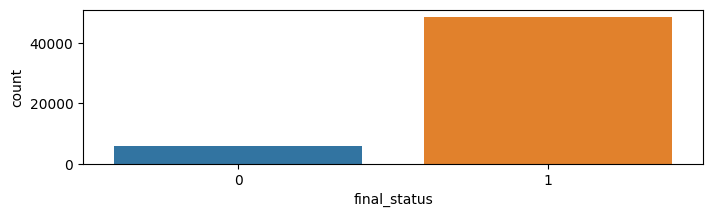

In [35]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(data=df_entrenar1, x='final_status')
plt.show()

In [36]:
entregados = df_entrenar1[df_entrenar1['final_status']==1]
cancelados = df_entrenar1[df_entrenar1['final_status']==0]

In [37]:
entregados = entregados.sample(len(cancelados), replace=False, random_state=41)

In [38]:
df_entrenar2 = pd.concat([entregados, cancelados])

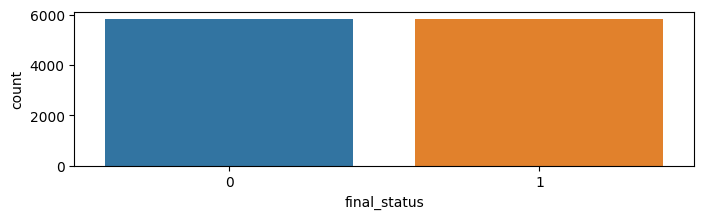

In [39]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(data=df_entrenar2, x='final_status')
plt.show()

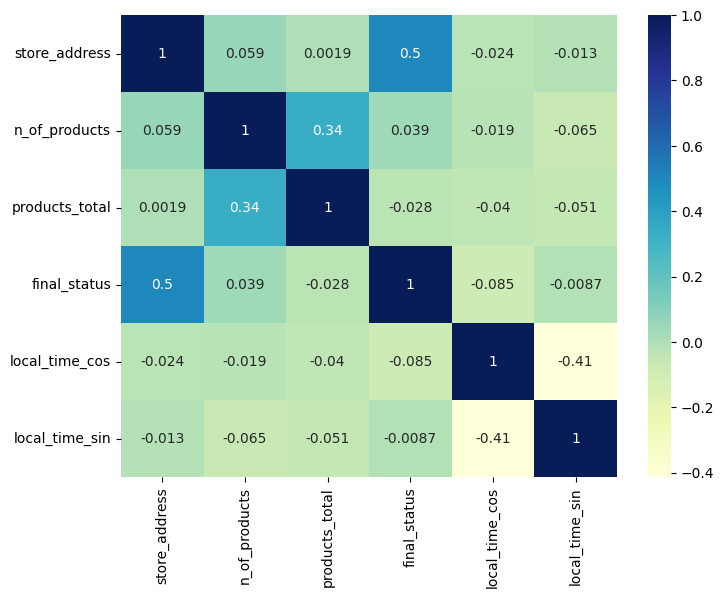

In [40]:
plt.rcParams['figure.figsize'] = 8, 6
sns.heatmap(df_entrenar2.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.show()

In [41]:
df_entrenar2 = pd.get_dummies(df_entrenar2)

In [42]:
df_entrenar2

,store_address,n_of_products,products_total,final_status,local_time_cos,local_time_sin,country_code_AR,country_code_EC,country_code_EG,country_code_ES,...,country_code_IT,country_code_MA,country_code_PE,country_code_RO,country_code_TR,country_code_UA,country_code_otro,payment_status_DELAYED,payment_status_NOT_PAID,payment_status_PAID
12008,0.900100,1,23.19,1,-9.659258e-01,-2.588190e-01,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
40768,0.939759,3,11.20,1,-1.000000e+00,1.224647e-16,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
8560,0.917503,2,7.24,1,-2.588190e-01,-9.659258e-01,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
996,0.972210,1,15.17,1,2.588190e-01,-9.659258e-01,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
36866,0.888271,3,10.90,1,-1.836970e-16,-1.000000e+00,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54258,0.782013,3,12.53,0,2.588190e-01,-9.659258e-01,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
54272,0.941591,1,10.90,0,2.588190e-01,-9.659258e-01,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
54284,0.716074,2,21.50,0,5.000000e-01,-8.660254e-01,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
54290,0.915969,1,2.01,0,5.000000e-01,-8.660254e-01,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [43]:
df_predecir1 = pd.get_dummies(df_predecir1)

In [45]:
df_entrenar2.shape

(11664, 21)

In [44]:
df_predecir1.shape

(10, 15)

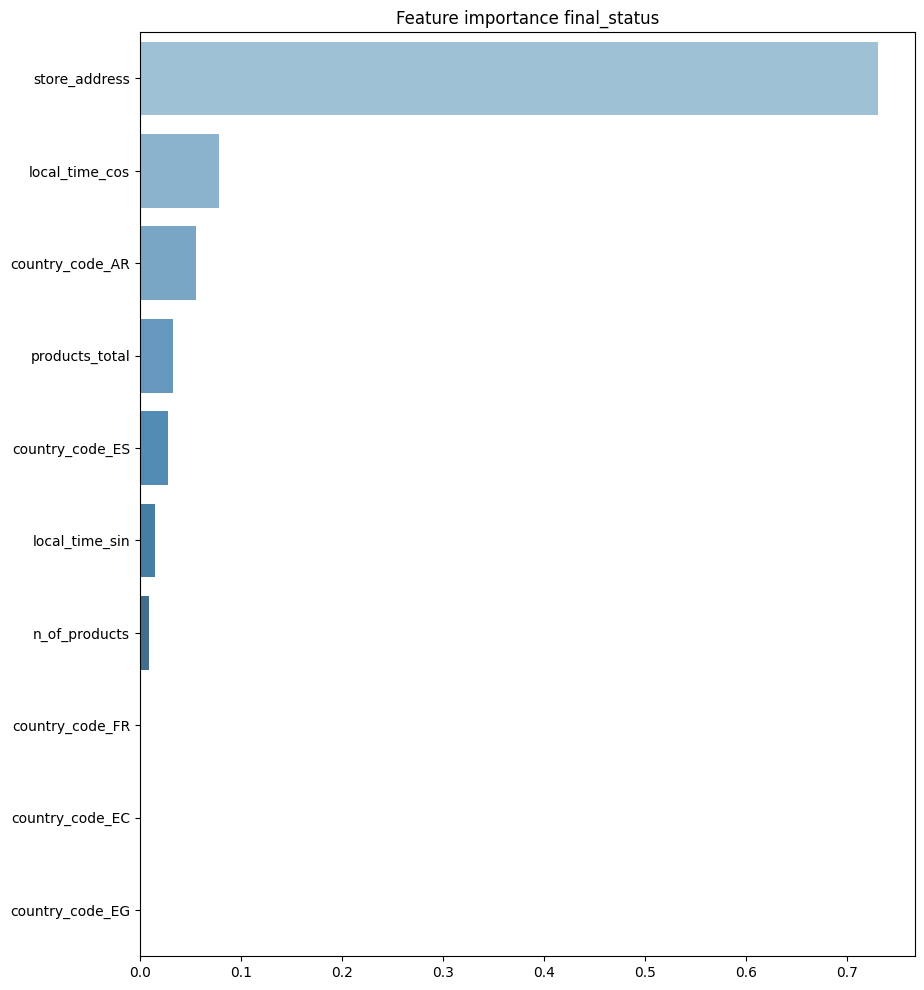

In [46]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df_entrenar2.drop('final_status',axis=1), df_entrenar2['final_status']
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plotea las 10 mejores Features importances
features = clf.feature_importances_[:10]
columnas = x.columns[:10]
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance {}".format('final_status'))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

In [47]:
# se guarda la target como y y las features como X
y = df_entrenar2['final_status']
X = df_entrenar2.drop('final_status', axis=1)

# se guarda un 30% de datos para el test y un 70% para el train con train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
X_train.shape

(8164, 20)

In [49]:
X_test.shape

(3500, 20)

In [50]:
# se estandarizan las variables con StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización
X_test = scaler.transform(X_test)         # estandariza según la regla definida con el X_train, con la media de X_train

In [ ]:
# # se estandarizan las variables del dataset a predecir según la regla definida con el X_train
# df_pred = scaler.transform(df_pred)


# # da error porque no tiene el mismo número de variables y con el mismo nombre que el dataset de entrenamiento

In [51]:
col_df_pred =df_predecir1.columns

In [52]:
col_df_entrenar = df_entrenar2.columns

In [53]:
columnas_faltantes = []
for i in col_df_entrenar:
  if i not in col_df_pred:
    columnas_faltantes.append(i)
columnas_faltantes

['final_status',
 'country_code_EG',
 'country_code_FR',
 'country_code_IT',
 'country_code_PE',
 'country_code_RO',
 'payment_status_DELAYED']

In [54]:
columnas_faltantes.remove('final_status')

In [55]:
# añadimos las columnas faltante al dataset de predicción con 0

for i in columnas_faltantes:
  df_predecir1[i] =[0]*len(df_predecir1)
df_predecir1

,store_address,n_of_products,products_total,local_time_cos,local_time_sin,country_code_AR,country_code_EC,country_code_ES,country_code_MA,country_code_TR,...,country_code_otro,payment_status_NOT_PAID,payment_status_PAID,payment_status_REFOUND,country_code_EG,country_code_FR,country_code_IT,country_code_PE,country_code_RO,payment_status_DELAYED
0,0.952106,4,15.99,-1.836970e-16,-1.000000,False,False,True,False,False,...,False,False,False,True,0,0,0,0,0,0
1,0.836957,2,1.79,-1.836970e-16,-1.000000,False,False,False,True,False,...,False,True,False,False,0,0,0,0,0,0
2,0.967858,4,29.89,-9.659258e-01,-0.258819,False,False,False,False,False,...,True,False,True,False,0,0,0,0,0,0
3,0.940363,1,1.47,-7.071068e-01,0.707107,False,False,False,False,True,...,False,False,True,False,0,0,0,0,0,0
4,0.843642,1,4.20,7.071068e-01,-0.707107,True,False,False,False,False,...,False,False,True,False,0,0,0,0,0,0
5,0.913890,4,18.73,-9.659258e-01,0.258819,False,False,False,False,False,...,False,False,True,False,0,0,0,0,0,0
6,0.849013,1,3.80,5.000000e-01,-0.866025,False,False,True,False,False,...,False,False,True,False,0,0,0,0,0,0
7,0.885050,1,6.25,-8.660254e-01,-0.500000,False,False,False,False,False,...,True,False,True,False,0,0,0,0,0,0
8,0.851702,2,14.50,7.071068e-01,-0.707107,False,False,True,False,False,...,False,False,True,False,0,0,0,0,0,0
9,0.909711,1,21.10,-1.836970e-16,-1.000000,False,True,False,False,False,...,False,False,True,False,0,0,0,0,0,0


In [56]:
col_sobrantes = []
for col in col_df_pred:
  if col not in col_df_entrenar:
    col_sobrantes.append(col)
col_sobrantes

['payment_status_REFOUND']

In [57]:
df_predecir1.drop(col_sobrantes, axis=1, inplace=True)

In [58]:
# verificamos que los dataset tienen el mismo número de variables

df_predecir1.shape[1] == X.shape[1]

True

In [59]:
# ponemos las columnas del dataset de predicción en el mismo orden que el de entrenamiento con reindex

columnas = X.columns
df_predecir1 = df_predecir1.reindex(columns=columnas)

In [60]:

# ya se pueden estandarizar las variables del dataset a predecir según la regla definida con el X_train con transform
df_predecir1 = scaler.transform(df_predecir1)

In [61]:
def medicion(y_t, y_p):
  """imprime la curva ROC y el AUC"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [63]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""

  # creamos la lista de auc vacía
  lista_aucs = []

  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)

  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))

  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)

  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))

  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)

  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))

  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)

  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))

  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)

  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))

  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)

  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))

  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)

  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))

  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)

  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))

  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')

  return df_aucs

Support Vector Machine


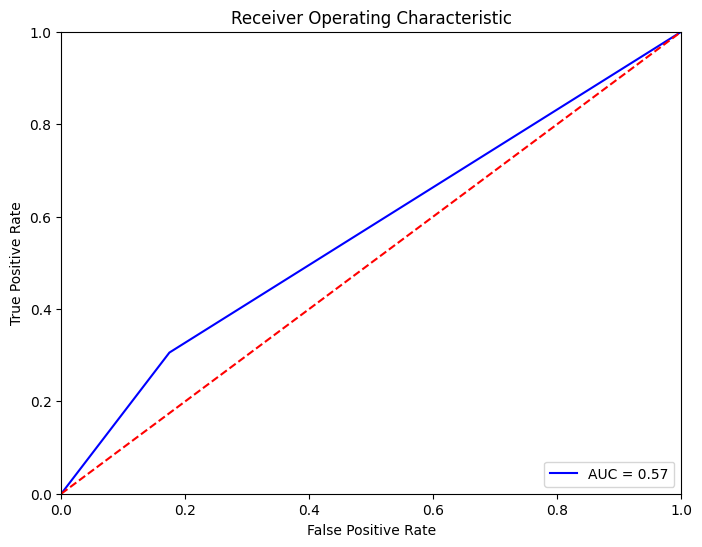

Regresión logística


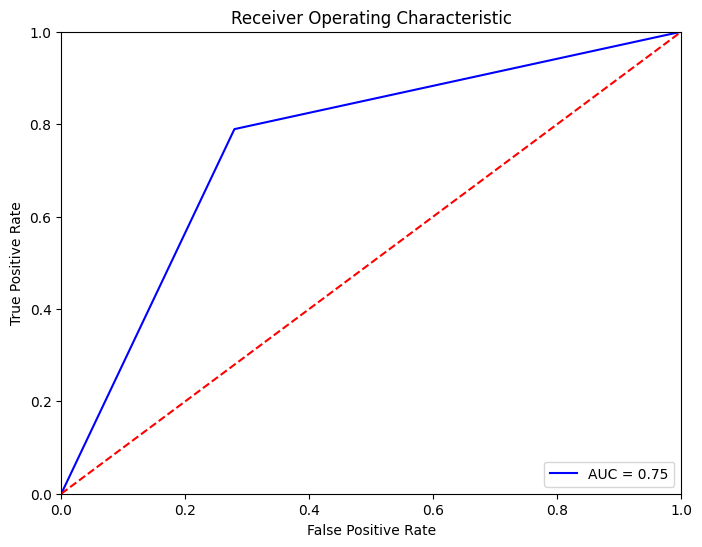

RidgeClassifier


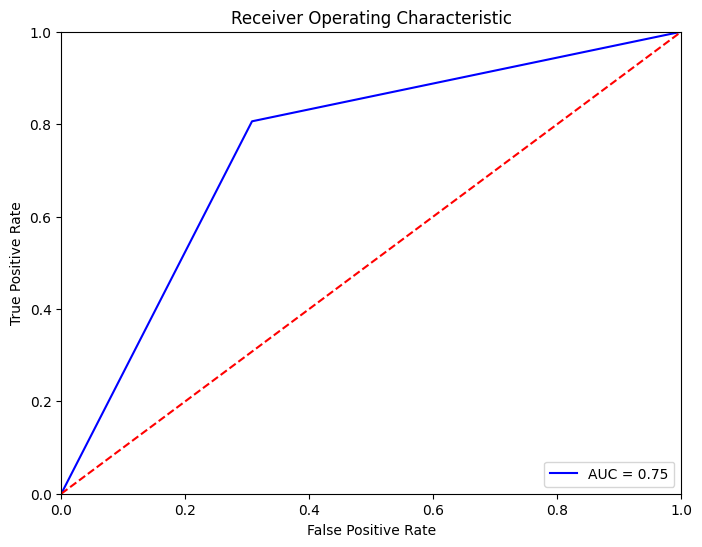

Decision tree classsifier


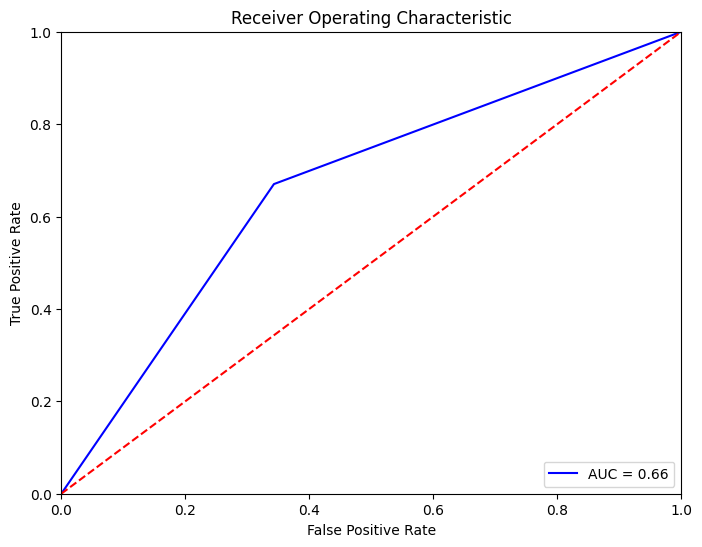

Random forest


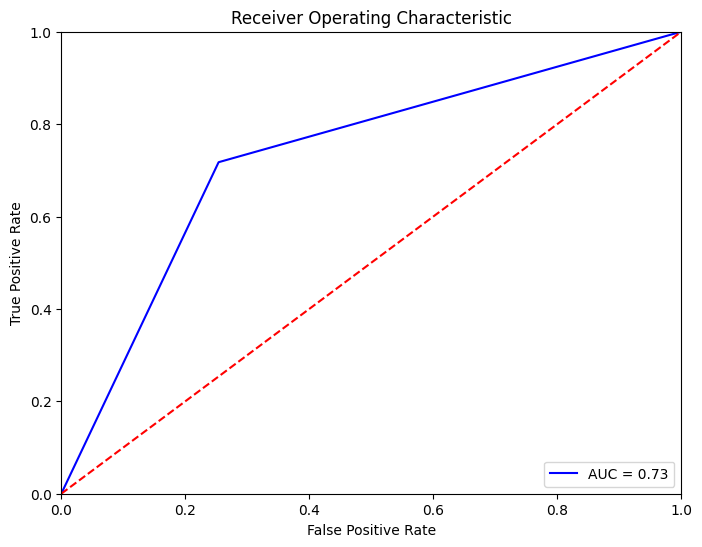

Gradient boosting


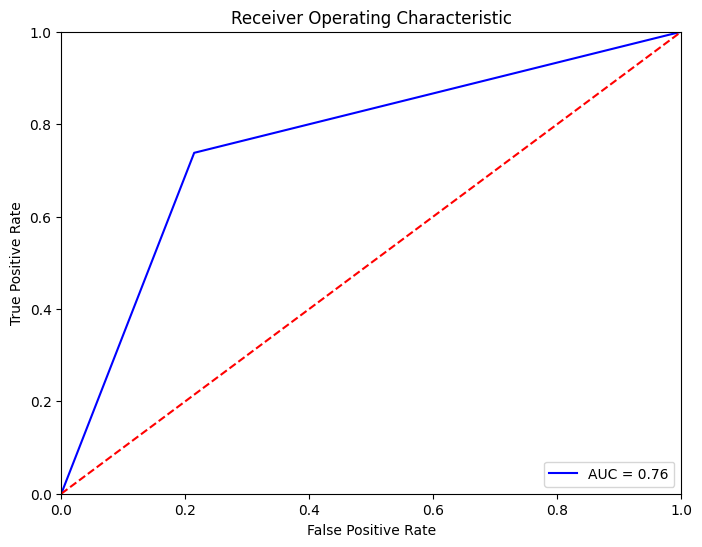

XGBClassifier


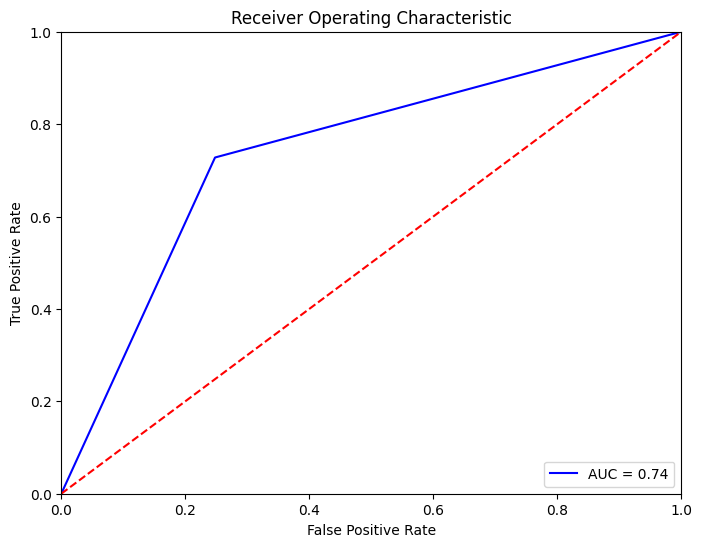

CatBoostClassifier


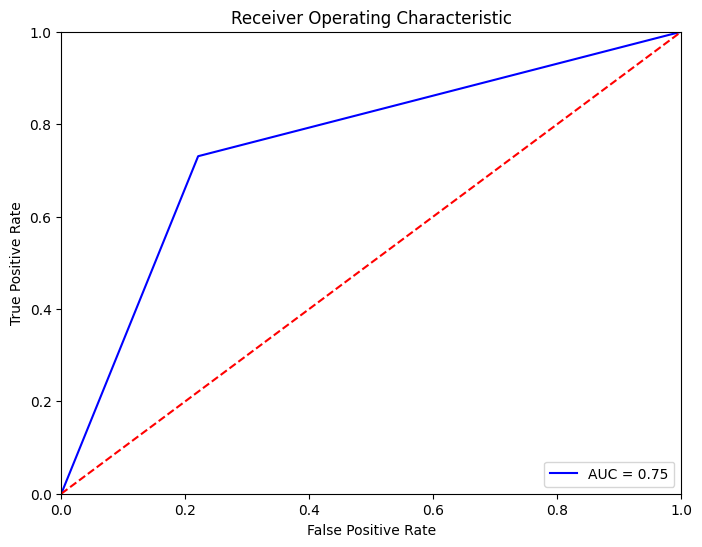

In [64]:
aucs = entrenar(X_train, X_test, y_train, y_test)

In [65]:
aucs

,AUC
modelos,
SVC,0.56557
regresión logística,0.75496
RidgeClassifier,0.74922
decision tree classifier,0.66362
random forest,0.73191
gradient boosting,0.76176
XGB classifier,0.73988
CatBoost Classifier,0.75491


## Hiperparametrización

In [66]:
# gridsearch
parameters = {'learning_rate': [0.03, 0.05, 0.1, 0.15],
              'n_estimators': [100, 300, 500],
              'max_depth': [3, 4, 5],
              'max_leaf_nodes': [None, 2, 3]}

In [67]:
gbc_hp =  GradientBoostingClassifier()

In [68]:
# se introducen los parametros del griedsearch
gbc = GradientBoostingClassifier(learning_rate=0.1, max_leaf_nodes=None, random_state=42)

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

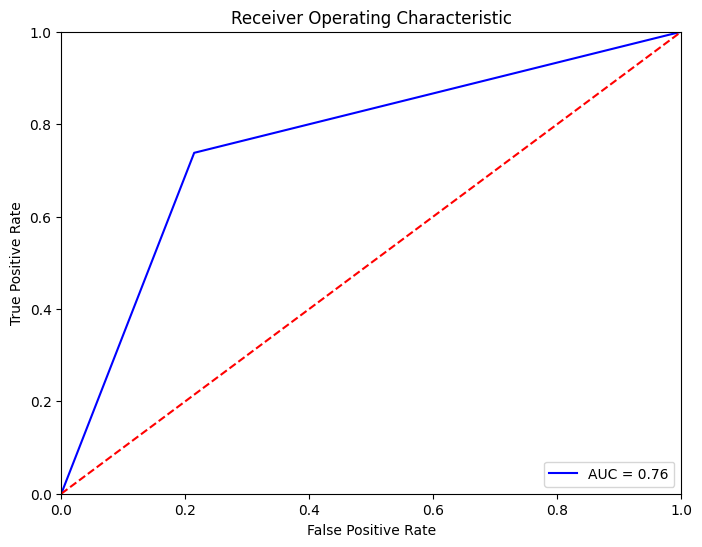

0.7617560070073589


In [69]:
roc_auc = medicion(y_test, y_pred)
print(roc_auc)

In [70]:
# se hace la predicción con predict

pred = gbc.predict(df_predecir1)
pred

array([1, 0, 1, 1, 0, 1, 0, 0, 0, 1])

In [71]:
# se hace la predicción con la probabilidad para cada categoría con predict_proba

pred_proba = gbc.predict_proba(df_predecir1)
pred_proba

array([[0.2595917 , 0.7404083 ],
       [0.93391217, 0.06608783],
       [0.16626307, 0.83373693],
       [0.25604337, 0.74395663],
       [0.64823226, 0.35176774],
       [0.2148096 , 0.7851904 ],
       [0.66269217, 0.33730783],
       [0.51561798, 0.48438202],
       [0.6560103 , 0.3439897 ],
       [0.22005596, 0.77994404]])

In [72]:
pred_proba2 = []
for tupla in pred_proba:
  pred_proba2.append(tupla[1])
pred_proba2

[0.7404083036693266,
 0.06608783325927275,
 0.8337369307936533,
 0.7439566324665615,
 0.3517677436136912,
 0.7851904036364641,
 0.3373078253835173,
 0.48438202363741867,
 0.3439896990450536,
 0.7799440443246438]